In [1]:
# Adapted from: Chapter 7 and 8 of Deep Learning with Pytorch by Eli Stevens (2020)
try:
    import torch as t
    import torch.nn as tnn
except ImportError:
    print("Colab users: pytorch comes preinstalled. Select Change Ru")
    print("Local users: Please install pytorch for your hardware using instructions from here: https://pytorch.org/get-started/locally/")
    print("ACG users: Please follow instructions here: https://vikasdhiman.info/ECE490-Neural-Networks/posts/0000-00-06-acg-slurm-jupyter/")
    
    raise

if t.cuda.is_available():
    DEVICE="cuda"
    t.cuda.set_device(t.device('cuda:0'))
else:
    DEVICE="cpu"

    
DTYPE = t.get_default_dtype()
print(f"Using {DEVICE=} and {DTYPE=}")

Using DEVICE='cuda' and DTYPE=torch.float32


In [2]:
# imports
import torch.nn
import torch.optim
import torchvision
from torchvision.transforms import Compose, Normalize, Resize
from torchvision.transforms.functional import to_tensor
from torch.utils.data import DataLoader, Dataset
from glob import glob
from PIL import Image
import re
import random
from pathlib import Path

In [3]:

# create a custom dataset for the images
class BiomeDataset(Dataset):
    """
    Dataset for the minecraft biome images
    """
    def __init__(self, data_dir: str, dir_is_paths=False, id_convert_dict=None):
        """
        Arguments:
            data_dir (str): Path to root data directory
            dir_is_paths (bool): If true, interprets data_dir as a list of images
        """
        # init transform to none
        self.transform = None

        if id_convert_dict is not None:
            self.id_to_class = id_convert_dict

        if dir_is_paths:
            self.paths = data_dir
            return
    
        # get the number of images in the dataset
        self.paths = glob(f"{data_dir}/*/*")
        dirs = glob(f"{data_dir}/*")

        self.id_to_class = {} # dictionary which converts a biome id to its class number
        self.data = []  # 2d array. First index indexes biome, second index indexes images
        for i, d in enumerate(dirs):
            self.data.append(glob(f"{d}/*"))
            self.id_to_class[int(re.search(r'[0-9]+', d)[0])] = i

        print(self.id_to_class) 
        print(len(self.id_to_class))   


    def split_data(self, percent_train: float, percent_val: float, seed: int):
        """
        Splits the Dataset per biome into three separate Datasets, 
        one for training, one for validation, and the remainder is for testing.
        """
        train = []
        val = []
        test = []

        rand = random.Random(seed) # TODO: broken af

        # for each biome, randomize the list and then split it
        for b in self.data:
            n_ims = len(b)
            rand.shuffle(b)
            ind1 = int(n_ims * percent_train)
            ind2 = int(n_ims * (percent_train +percent_val))
            train += b[:ind1]
            val += b[ind1:ind2]
            test += b[ind2:]

        return (BiomeDataset(train, dir_is_paths=True, id_convert_dict=self.id_to_class), 
            BiomeDataset(val, dir_is_paths=True, id_convert_dict=self.id_to_class),
            BiomeDataset(test, dir_is_paths=True, id_convert_dict=self.id_to_class))

    
    def get_class_sizes(self, id_to_class: dict):
        """
        Returns a list ordered by class type (0-n_classes) where each element is
        the number of classes for that type. Used by the balanced_loss.py module
        
        Uses the id_to_class dict to convert the file paths to class numbers
        """
        sizes = [0 for i in list(id_to_class.keys())] # init to zero
        for p in self.paths:
            label = int(re.search(r'[0-9]+', p)[0])
            sizes[id_to_class[label]] += 1
        return sizes
            
    
    def set_transform(self, transform):
        """
        updates the transform that the dataset will use when transforming images
        """
        self.transform = transform


    def __getitem__(self, idx):
        """
        Returns a tuple of (image: ndarray, label: int)
        """

        imname = self.paths[idx]
        image = Image.open(imname)
        image = to_tensor(image).cuda()  # converts to float tensor
        # apply transforms
        if self.transform is not None:
            image = self.transform(image)
    
        label = int(re.search(r'[0-9]+', imname)[0])
        label = self.id_to_class[label]
        return (image, label)


    def __len__(self):
        return len(self.paths)


all_data = BiomeDataset('../scraping/preprocessed_data')

{27: 0, 21: 1, 11: 2, 156: 3, 4: 4, 39: 5, 32: 6, 16: 7, 34: 8, 13: 9, 35: 10, 3: 11, 6: 12, 131: 13, 37: 14, 7: 15, 22: 16, 17: 17, 158: 18, 18: 19, 45: 20, 31: 21, 29: 22, 157: 23, 28: 24, 132: 25, 26: 26, 33: 27, 1: 28, 12: 29, 162: 30, 130: 31, 36: 32, 19: 33, 129: 34, 5: 35, 30: 36, 38: 37, 133: 38, 2: 39, 10: 40}
41


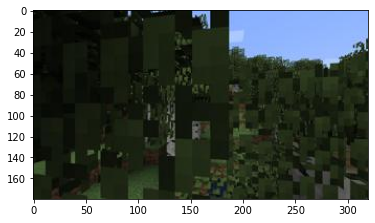

In [4]:
# example image from the dataset
import matplotlib.pyplot as plt
im, label = all_data[3]
plt.imshow(im.cpu().permute(1, 2, 0))

In [5]:
# split up the data
train_data, val_data, test_data = all_data.split_data(0.7, 0.2, 5)
train_data[0][0].shape

torch.Size([3, 180, 320])

In [6]:
# Normalize the data over each channel
DATA_INFO_FILE = "dataset_info.txt"
if Path(DATA_INFO_FILE).exists():
    print('Loading known dataset information for normalization')
    
    means = torch.Tensor([0, 0, 0])
    std = torch.Tensor([0, 0, 0])
    with open(DATA_INFO_FILE, 'r') as f:
        m = f.readline().replace('\n', '').split(' ')
        means[0] = float(m[0])
        means[1] = float(m[1])
        means[2] = float(m[2])
        s = f.readline().replace('\n', '').split(' ')
        std[0] = float(s[0])# * 4 # TODO: Temporary hack to reduce exploding gradient problems
        std[1] = float(s[1])# * 4
        std[2] = float(s[2])# * 4
        print("Loaded means", m)
        print("Loaded std", s)

else:
    # compute the means across each channel for the whole training dataset
    means = torch.Tensor([0, 0, 0]).cuda()
    for i in range(len(train_data)):
        im = train_data[i][0]
        means += torch.mean(im, dim=[1,2]) 
        if i % 1000 == 0:
            print(f"Calculating dataset means: {i}/{len(train_data)}")

    means = means / i

    print(means)

    # compute the stdev across each channel for the whole training dataset
    sumel = 0.0
    countel = 0
    for i in range(len(train_data)):
        img = train_data[i][0]
        img = (img - means.unsqueeze(1).unsqueeze(1))**2
        sumel += img.sum([1, 2])
        countel += torch.numel(img[0])
        if i % 1000 == 0:
            print(f"Calculating dataset stdevs: {i}/{len(train_data)}")

    std = torch.sqrt(sumel/countel)

    print(std)

    # save dataset info so that it doesn't need to be recalculated
    with open(DATA_INFO_FILE, 'w') as f:
        f.write(f"{means[0]} {means[1]} {means[2]}\n")
        f.write(f"{std[0]} {std[1]} {std[2]}\n")
        
# normalize the training and validation datasets based on the mean and stedv 
# of the training dataset
# IMAGE_SIZE = (720//10, 1280//10)
transform_img = Compose([
    # Resize(IMAGE_SIZE, antialias=True), # ensure all images are the proper size
    Normalize(mean=means, std=std)
])

train_data.set_transform(transform_img)
val_data.set_transform(transform_img)
test_data.set_transform(transform_img)

# get the number of instances of each class in the training set
training_class_counts = train_data.get_class_sizes(all_data.id_to_class)
print(training_class_counts)

Loading known dataset information for normalization
Loaded means ['0.38232675194740295', '0.44096899032592773', '0.44938528537750244']
Loaded std ['0.2428676337003708', '0.2687499225139618', '0.38880330324172974']
[571, 210, 33, 16, 1906, 29, 189, 298, 428, 331, 701, 1726, 465, 54, 75, 277, 100, 331, 4, 495, 12, 62, 567, 42, 197, 88, 79, 62, 2108, 877, 75, 58, 113, 247, 121, 1117, 226, 42, 25, 1071, 71]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-1.6408, device='cuda:0')
tensor(2.0104, device='cuda:0')


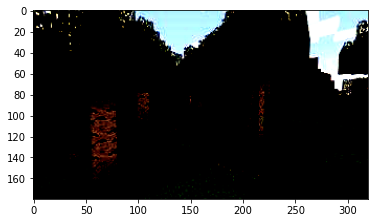

In [7]:
# now a glance at the normalized data. 
im, label = train_data[1]
print(torch.min(im))
print(torch.max(im))

plt.imshow(im.cpu().permute(1, 2, 0))

In [8]:
# Hyperparameters
hyperparams = {
    "batch_size": 64,
    "learning_rate": 1e-3,
    "epochs": 300,
    "momentum": 0.9,
    "weight_decay": 0.01, # The L-2 normalization penalty used by the optimizer
    "dropout_rate": 0,
    "loss_f": "FocalLoss",
    "gamma": 2,    # focal loss parameter. The paper found that gamma=2 was optimal for their network
    "beta": 0.99
}

# Create the dataloaders. drop_last=True ignores the last, incomplete batch for evaluation compatibility
training_dataloader = DataLoader(train_data, batch_size=hyperparams['batch_size'], shuffle=True, drop_last=True)
validation_dataloader = DataLoader(val_data, batch_size=hyperparams['batch_size'], shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_data, batch_size=hyperparams['batch_size'], shuffle=True, drop_last=True)

In [9]:
# Model definition
from modules.losses import Loss
#loss = focalloss.FocalLoss(hyperparams['gamma'], hyperparams['alpha']) # sed for binary classification?
loss = Loss(
    loss_type="focal_loss",
    beta=hyperparams['beta'], # class-balanced loss beta
    fl_gamma=hyperparams['gamma'], 
    samples_per_class=training_class_counts,
    class_balanced=True
    )

class ConvNeuralNet(tnn.Module):
    #  Determine what layers and their order in CNN object
    # Code from https://blog.paperspace.com/writing-cnns-from-scratch-in-pytorch/
    def __init__(self, num_classes, dropout_rate):
        super(ConvNeuralNet, self).__init__()
        self.conv_layer1 = tnn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, padding='same')
        self.drop1 = tnn.Dropout(dropout_rate)
        self.conv_layer2 = tnn.Conv2d(in_channels=16, out_channels=16, kernel_size=5, padding='same')
        self.batch_norm1 = tnn.BatchNorm2d(16)
        self.max_pool1 = tnn.MaxPool2d(kernel_size = 2, stride = 2)
        
        self.conv_layer3 = tnn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding='same')
        self.drop2 = tnn.Dropout(dropout_rate)
        self.conv_layer4 = tnn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding='same')
        self.batch_norm2 = tnn.BatchNorm2d(32)
        self.max_pool2 = tnn.MaxPool2d(kernel_size = 2, stride = 2)

        self.conv_layer5 = tnn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding='same')
        self.drop3 = tnn.Dropout(dropout_rate)
        self.conv_layer6 = tnn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding='same')
        self.batch_norm3 = tnn.BatchNorm2d(64)
        self.max_pool3 = tnn.MaxPool2d(kernel_size = 2, stride = 2)        

        self.conv_layer7 = tnn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding='same')
        self.drop4 = tnn.Dropout(dropout_rate)
        self.conv_layer8 = tnn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding='same')
        self.batch_norm4 = tnn.BatchNorm2d(128)
        self.max_pool4 = tnn.MaxPool2d(kernel_size = 2, stride = 2)    
        
        self.fc1 = tnn.Linear(28160, 128)
        self.relu1 = tnn.ReLU()
        self.dropend = tnn.Dropout(p=0.5) # accordding to literature, in FC layers dropout=0.5 is best
        self.fc2 = tnn.Linear(128, num_classes)
    
    # Progresses data across layers    
    def forward(self, x):
        out = self.conv_layer1(x)
        out = self.drop1(out)
        out = self.conv_layer2(out)
        out = self.batch_norm1(out)
        out = self.max_pool1(out)
        
        out = self.conv_layer3(out)
        out = self.drop2(out)
        out = self.conv_layer4(out)
        out = self.batch_norm2(out)
        out = self.max_pool2(out)
        
        out = self.conv_layer5(out)
        out = self.drop3(out)
        out = self.conv_layer6(out)
        out = self.batch_norm3(out)
        out = self.max_pool3(out)

        out = self.conv_layer7(out)
        out = self.drop4(out)
        out = self.conv_layer8(out)
        out = self.batch_norm4(out)
        out = self.max_pool4(out)
        
        out = out.reshape(out.size(0), -1)
        
        out = self.fc1(out)
        out = self.relu1(out)
        out = self.dropend(out)
        out = self.fc2(out)
        return out

    # Get model results for inputs
    def step(self, inputs):
        data, labels = inputs
        outputs = self(data)
        _, preds = torch.max(outputs.data , 1)
        return preds, labels
    
    # get predictions for entire dataloader
    def predict(self, dataloader):
        predictions = torch.Tensor()
        labels = torch.Tensor()
        self.eval() # put in eval mode
        for i, batch in enumerate(dataloader):
            pred, label = self.step(batch)
            predictions = torch.cat((predictions, pred.cpu()))
            labels = torch.cat((labels, label.cpu()))
        return predictions, labels
    
    
model = ConvNeuralNet(len(training_class_counts), hyperparams['dropout_rate'])
model.cuda()

# Define optimizer
optimizer = torch.optim.SGD(model.parameters(), 
                            lr=hyperparams['learning_rate'], 
                            momentum=hyperparams['momentum'], 
                            weight_decay=hyperparams['weight_decay']
                            )

# deine learning rate scheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau
scheduler = ReduceLROnPlateau(optimizer, mode='min',
                            patience=10, factor=0.5
                            )

# check what device model is being stored on
print("Is cuda being used for the model?", all([p.is_cuda for p in model.parameters()]))

Is cuda being used for the model? True


In [10]:
from torch.utils.tensorboard import SummaryWriter
import os, datetime
writer = SummaryWriter()

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def loss_and_accuracy(model, loss, validation_dataloader, device=DEVICE):
        # Validation loop
        validation_size = len(validation_dataloader.dataset)
        num_batches = len(validation_dataloader)
        test_loss, correct = 0, 0
        
        with torch.no_grad():
            model.eval() # Put model in eval mode, affects layers like dropout and batchnorm
            for X, y in validation_dataloader:
                X = X.to(device)
                y = y.to(device)
                pred = model(X)
                test_loss += loss(pred, y)
                correct += (pred.argmax(dim=-1) == y).type(DTYPE).sum()

        test_loss /= num_batches
        correct /= validation_size
        return test_loss, correct
    
def train(model, loss, training_dataloader, validation_dataloader, epochs, device=DEVICE, chkpt_name='model_ckpt.pt', ignore_chkpt=False):
    model.to(device)
    t0 = 0
    if not ignore_chkpt and os.path.exists(f"runs/{chkpt_name}"):
        checkpoint = torch.load(f"runs/{chkpt_name}")
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        t0 = checkpoint['epoch']
        
    # Keep track of train and val losses so that we can plot it easily after the training is complete
    train_losses = []
    val_losses = []
    
    for t in range(t0, epochs):
        # Train loop
        training_size = len(training_dataloader.dataset)
        nbatches = len(training_dataloader)
        model.train() # Put model in train mode, affects layers like dropout and batchnorm
        for batch, (X, y) in enumerate(training_dataloader):
            X = X.to(device)
            y = y.to(device)
            # Compute prediction and loss
            pred = model(X)
            loss_t = loss(pred, y)

            # Backpropagation
            optimizer.zero_grad()
            loss_t.backward()
            optimizer.step()

            if batch % 1 == 0:
                writer.add_scalar("Train/loss_batch", loss_t,  t*nbatches + batch)
                loss_t, current = loss_t.item(), (batch + 1) * len(X)
                print(f"loss: {loss_t:>7f}  [{current:>5d}/{training_size:>5d}]", end="\r")
                
        writer.add_scalar("Train/loss", loss_t, t)
        valid_loss, correct = loss_and_accuracy(model, loss, validation_dataloader, device=device)
        
        # step the learning rate shceduler
        scheduler.step(valid_loss)
        
        writer.add_scalar("Valid/loss", valid_loss, t)
        writer.add_scalar("Valid/accuracy", correct, t)
        print(f"\nValidation Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {valid_loss:>8f}. Learning rate: {get_lr(optimizer):>8f}. Completed epoch {t+1}/{epochs} \n")
        
        train_losses.append(float(loss_t))
        val_losses.append(float(valid_loss))
        
        if t % 3 == 0:
            torch.save({
                'epoch': t,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict()
                }, f"runs/{chkpt_name}")
    return model, train_losses, val_losses
        
    
print(f"Training model using device {DEVICE}. Started at {datetime.datetime.now()}")
trained_model, train_losses, val_losses = train(model, loss, training_dataloader, validation_dataloader, 
                    hyperparams['epochs'], chkpt_name='linear_model_chkpt.pt', ignore_chkpt=True)


Training model using device cuda. Started at 2023-04-25 15:35:24.009190
loss: 0.568021  [15488/15499]
Validation Error: 
 Accuracy: 30.1%, Avg loss: 0.682729. Learning rate: 0.001000. Completed epoch 2/300 

loss: 0.384147  [15488/15499]
Validation Error: 
 Accuracy: 32.4%, Avg loss: 0.693150. Learning rate: 0.001000. Completed epoch 3/300 

loss: 0.368456  [15488/15499]
Validation Error: 
 Accuracy: 31.5%, Avg loss: 0.804917. Learning rate: 0.001000. Completed epoch 4/300 

loss: 0.373519  [15488/15499]
Validation Error: 
 Accuracy: 26.3%, Avg loss: 0.855908. Learning rate: 0.001000. Completed epoch 5/300 

loss: 0.369796  [15488/15499]
Validation Error: 
 Accuracy: 27.5%, Avg loss: 0.880795. Learning rate: 0.001000. Completed epoch 6/300 

loss: 0.312323  [15488/15499]
Validation Error: 
 Accuracy: 25.6%, Avg loss: 0.842682. Learning rate: 0.001000. Completed epoch 7/300 

loss: 0.386344  [15488/15499]
Validation Error: 
 Accuracy: 26.7%, Avg loss: 0.926749. Learning rate: 0.001000. 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



loss: 0.259721  [15488/15499]
Validation Error: 
 Accuracy: 23.3%, Avg loss: 1.079235. Learning rate: 0.000063. Completed epoch 50/300 

loss: 0.227725  [15488/15499]
Validation Error: 
 Accuracy: 22.4%, Avg loss: 1.064510. Learning rate: 0.000063. Completed epoch 51/300 

loss: 0.237925  [15488/15499]
Validation Error: 
 Accuracy: 23.6%, Avg loss: 1.096377. Learning rate: 0.000063. Completed epoch 52/300 

loss: 0.317222  [15488/15499]
Validation Error: 
 Accuracy: 23.5%, Avg loss: 1.121011. Learning rate: 0.000063. Completed epoch 53/300 

loss: 0.227642  [15488/15499]
Validation Error: 
 Accuracy: 24.8%, Avg loss: 1.086805. Learning rate: 0.000063. Completed epoch 54/300 

loss: 0.271589  [15488/15499]
Validation Error: 
 Accuracy: 24.8%, Avg loss: 1.116847. Learning rate: 0.000063. Completed epoch 55/300 

loss: 0.309487  [15488/15499]
Validation Error: 
 Accuracy: 26.4%, Avg loss: 1.068360. Learning rate: 0.000063. Completed epoch 56/300 

loss: 0.252294  [15488/15499]
Validation 

loss: 0.278810  [15488/15499]
Validation Error: 
 Accuracy: 23.5%, Avg loss: 1.122710. Learning rate: 0.000002. Completed epoch 110/300 

loss: 0.273529  [15488/15499]
Validation Error: 
 Accuracy: 23.0%, Avg loss: 1.115523. Learning rate: 0.000002. Completed epoch 111/300 

loss: 0.308184  [15488/15499]
Validation Error: 
 Accuracy: 24.1%, Avg loss: 1.091916. Learning rate: 0.000001. Completed epoch 112/300 

loss: 0.315904  [15488/15499]
Validation Error: 
 Accuracy: 24.3%, Avg loss: 1.120636. Learning rate: 0.000001. Completed epoch 113/300 

loss: 0.244121  [15488/15499]
Validation Error: 
 Accuracy: 23.7%, Avg loss: 1.091136. Learning rate: 0.000001. Completed epoch 114/300 

loss: 0.264050  [15488/15499]
Validation Error: 
 Accuracy: 24.2%, Avg loss: 1.109104. Learning rate: 0.000001. Completed epoch 115/300 

loss: 0.269489  [15488/15499]
Validation Error: 
 Accuracy: 23.8%, Avg loss: 1.129131. Learning rate: 0.000001. Completed epoch 116/300 

loss: 0.284988  [15488/15499]
Vali

loss: 0.300290  [15488/15499]
Validation Error: 
 Accuracy: 23.2%, Avg loss: 1.130724. Learning rate: 0.000000. Completed epoch 170/300 

loss: 0.249889  [15488/15499]
Validation Error: 
 Accuracy: 23.6%, Avg loss: 1.131676. Learning rate: 0.000000. Completed epoch 171/300 

loss: 0.221276  [15488/15499]
Validation Error: 
 Accuracy: 23.3%, Avg loss: 1.107577. Learning rate: 0.000000. Completed epoch 172/300 

loss: 0.242905  [15488/15499]
Validation Error: 
 Accuracy: 23.8%, Avg loss: 1.117292. Learning rate: 0.000000. Completed epoch 173/300 

loss: 0.380627  [15488/15499]
Validation Error: 
 Accuracy: 23.5%, Avg loss: 1.112496. Learning rate: 0.000000. Completed epoch 174/300 

loss: 0.254339  [15488/15499]
Validation Error: 
 Accuracy: 24.1%, Avg loss: 1.133692. Learning rate: 0.000000. Completed epoch 175/300 

loss: 0.276333  [15488/15499]
Validation Error: 
 Accuracy: 23.8%, Avg loss: 1.144291. Learning rate: 0.000000. Completed epoch 176/300 

loss: 0.258462  [15488/15499]
Vali

loss: 0.236933  [15488/15499]
Validation Error: 
 Accuracy: 23.4%, Avg loss: 1.097689. Learning rate: 0.000000. Completed epoch 230/300 

loss: 0.233394  [15488/15499]
Validation Error: 
 Accuracy: 23.3%, Avg loss: 1.149183. Learning rate: 0.000000. Completed epoch 231/300 

loss: 0.283570  [15488/15499]
Validation Error: 
 Accuracy: 23.3%, Avg loss: 1.122734. Learning rate: 0.000000. Completed epoch 232/300 

loss: 0.240560  [15488/15499]
Validation Error: 
 Accuracy: 23.3%, Avg loss: 1.118383. Learning rate: 0.000000. Completed epoch 233/300 

loss: 0.228625  [15488/15499]
Validation Error: 
 Accuracy: 23.8%, Avg loss: 1.106922. Learning rate: 0.000000. Completed epoch 234/300 

loss: 0.282994  [15488/15499]
Validation Error: 
 Accuracy: 24.1%, Avg loss: 1.110008. Learning rate: 0.000000. Completed epoch 235/300 

loss: 0.273332  [15488/15499]
Validation Error: 
 Accuracy: 23.6%, Avg loss: 1.122218. Learning rate: 0.000000. Completed epoch 236/300 

loss: 0.284714  [15488/15499]
Vali

loss: 0.271600  [15488/15499]
Validation Error: 
 Accuracy: 23.3%, Avg loss: 1.126829. Learning rate: 0.000000. Completed epoch 290/300 

loss: 0.257479  [15488/15499]
Validation Error: 
 Accuracy: 23.5%, Avg loss: 1.121622. Learning rate: 0.000000. Completed epoch 291/300 

loss: 0.240621  [15488/15499]
Validation Error: 
 Accuracy: 23.4%, Avg loss: 1.091473. Learning rate: 0.000000. Completed epoch 292/300 

loss: 0.249753  [15488/15499]
Validation Error: 
 Accuracy: 23.5%, Avg loss: 1.110817. Learning rate: 0.000000. Completed epoch 293/300 

loss: 0.367315  [15488/15499]
Validation Error: 
 Accuracy: 23.9%, Avg loss: 1.120255. Learning rate: 0.000000. Completed epoch 294/300 

loss: 0.297953  [15488/15499]
Validation Error: 
 Accuracy: 23.8%, Avg loss: 1.116644. Learning rate: 0.000000. Completed epoch 295/300 

loss: 0.329554  [15488/15499]
Validation Error: 
 Accuracy: 23.3%, Avg loss: 1.127739. Learning rate: 0.000000. Completed epoch 296/300 

loss: 0.298927  [15488/15499]
Vali

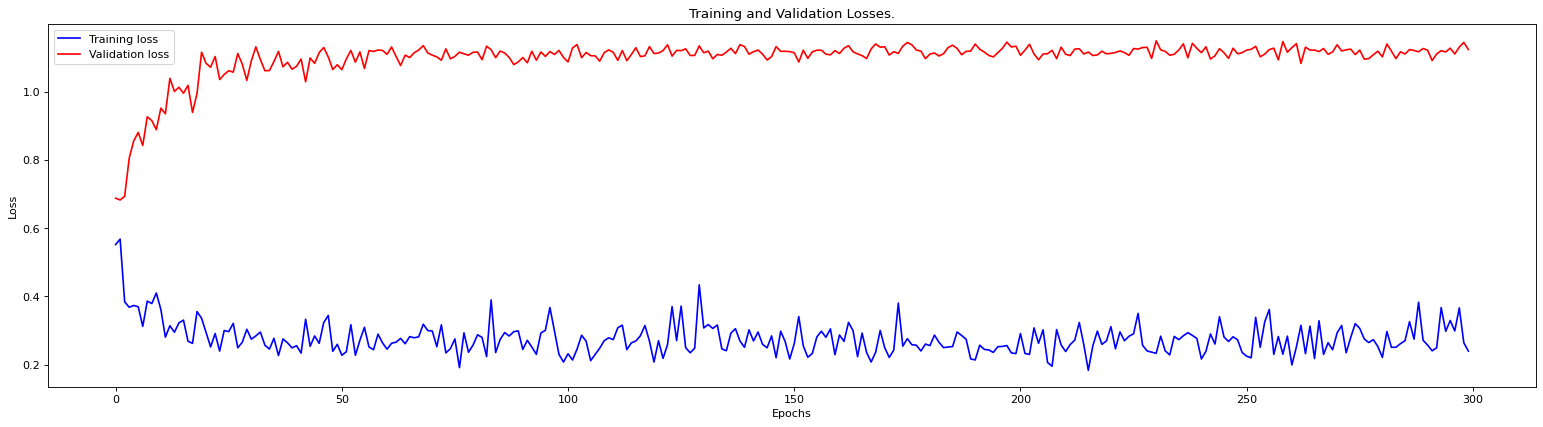

In [11]:
import numpy as np
# plot the losses
def plot_losses(train_loss, val_loss):
    t_loss = np.asarray(train_loss, dtype=float)
    v_loss = np.asarray(val_loss, dtype=float)
    epochs = range(len(train_loss))
    
    plt.figure(figsize=(24, 6), dpi=80)
    plt.plot(epochs, t_loss, "b", label="Training loss")
    plt.plot(epochs, v_loss, "r", label="Validation loss")
    plt.title("Training and Validation Losses.")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    
    plt.show()
    
plot_losses(train_losses, val_losses)

In [12]:
from modules import train_info as ti # custom module

import importlib
importlib.reload(ti) # ensure code changes are applied (otherwise jupyter does not reimport)

ok
ok


<module 'modules.train_info' from '/home/wcunningham/biome_detector/networks/modules/train_info.py'>

In [13]:
# Evaluate the model

pred, labels = model.predict(training_dataloader)
accuracies_train, accuracy_train = ti.per_class_accuracies(pred, labels)

print("Overall training accuracy:", accuracy_train)
#print("Training accuracy by class:\n", accuracies_train)

pred, labels = model.predict(test_dataloader)
accuracies_test, accuracy_test = ti.per_class_accuracies(pred, labels)

print("Overall testing accuracy:", accuracy_test)
#print("Training accuracy by class:\n", accuracies_test)

Overall training accuracy: 0.23456869834710745
Overall testing accuracy: 0.23169642857142858


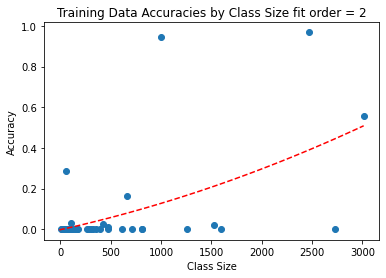

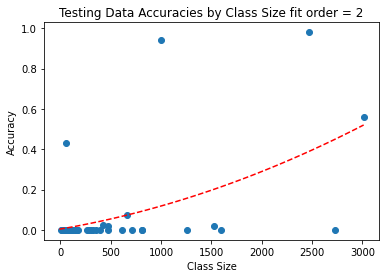

'logs/trainlog_2023-04-25T19-49-55-622822.json'

In [14]:
# calculate, save, and dispay information on this run
sizes = ti.get_class_sizes(all_data.data)

# train accuracies plot
ti.plot_accuracies(accuracies_train, sizes, "Training Data Accuracies by Class Size")
# test accuracies plot
ti.plot_accuracies(accuracies_test, sizes, "Testing Data Accuracies by Class Size")

# save the data to a json file
ti.write_info(hyperparams, accuracies_train, accuracies_test, sizes)

In [15]:
# save the model out
saving = False
if saving:
    torch.save(trained_model.state_dict(), "detector_model.pt")